## Confront the NPZ model with real data from Narragansett Bay
### 1. A first look at the data

In [1]:
using StanSample, CSV, DataFrames, PyPlot, Statistics

┌ Info: Precompiling StanSample [c1514b29-d3a0-5178-b312-660c88baa699]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


In [2]:
versioninfo()

Julia Version 1.3.0
Commit 46ce4d7933 (2019-11-26 06:09 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin19.0.0)
  CPU: Intel(R) Core(TM) i9-8950HK CPU @ 2.90GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)
Environment:
  JULIA_CMDSTAN_HOME = /Users/zhenwu/Zhen_WU/cmdstan


In [3]:
data = CSV.read("data/data_npz_narragansett.csv");

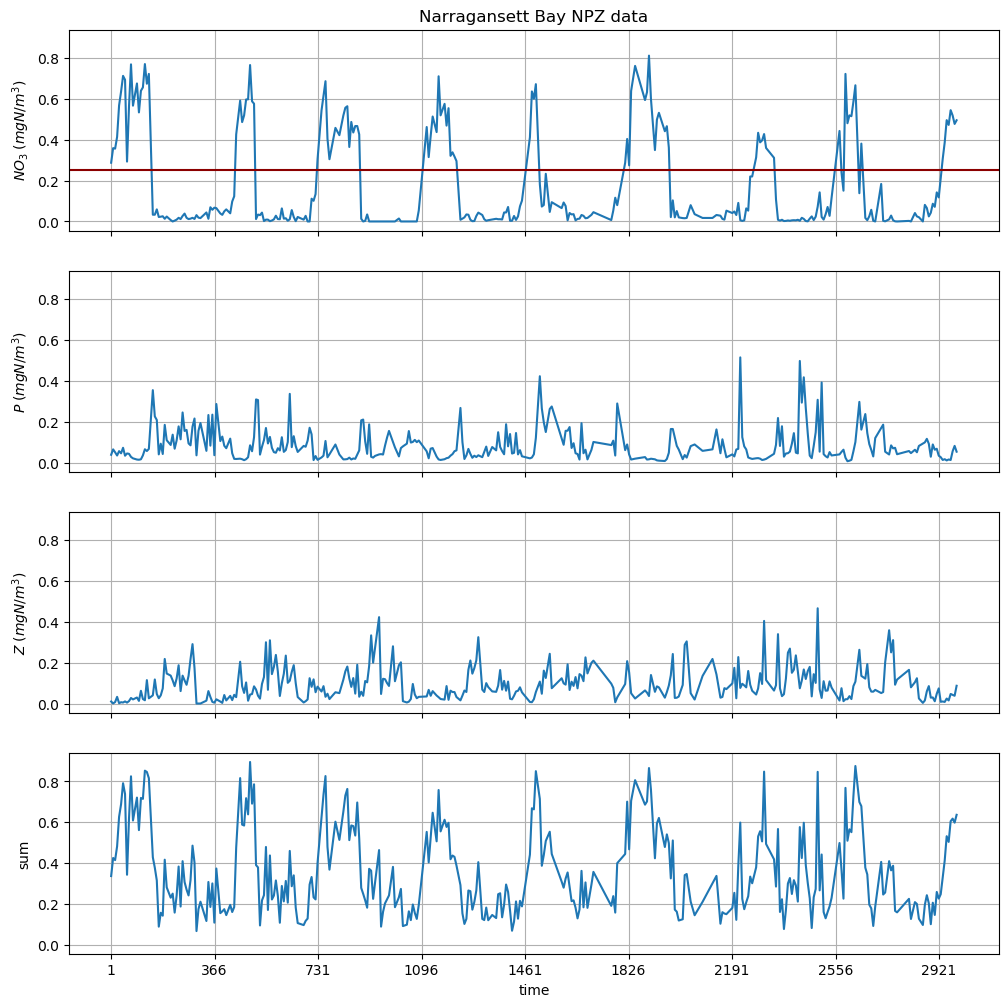

In [4]:
data_names = [L"NO_3\;(mgN/m^3)",L"P\;(mgN/m^3)",L"Z\;(mgN/m^3)"]
fig, axs = plt.subplots(nrows=4, sharex=true, sharey=true, figsize=(12,12))
for i in 1:3
    axs[i].plot(data[:,1], data[:,i+1])
    axs[i].set_ylabel(data_names[i])
    axs[i].grid(true)
end
axs[1].set_title("Narragansett Bay NPZ data")
axs[1].axhline(0.25, color="darkred")
axs[4].plot(data[:,1],  data[:,2]+data[:,3]+data[:,4])
    axs[4].set(xlabel="time", ylabel="sum", xticks=collect(1:365:data[end,1]))
axs[4].grid(true)

#### challenges for fitting data:
- high noise level
- no conservation of mass while NPZ model conserves mass

### 2. Modifications to the NPZ mode   
allow influx and loss of N in the model:
- introduce a background concentration for each variable and allow mixing with that background concentration
- have a winter period for each year with stronger mixing and different background concentrations
- estimate start and duration of winter period for each year (initial guess is based on data)
- estimate background concentrations for winter and regular period (same for each year)

In [5]:
# base initial guess of start and duration of the winter period based on N crossing a 0.25 threshold

stan_code_dataparams = """data {
    int<lower=0> nobs;               // number of timesteps with observations
    real<lower=0> tobs[nobs];        // obs times
    int<lower=0> nobsvar;            // number of observed variables
    int<lower=0> iobsvar[nobsvar];   // index of observed variable (N=1, P=2, Z=3)
    real<lower=0> obs[nobs,nobsvar]; // observed variable at measurement times
    int<lower=0> nyears;             // number of years (number of winters to add to the model)
}
transformed data {
    real wintermixstart_guess[nyears];
    real wintermixduration_guess[nyears];
    {
        int start = 0;
        int iyear = 1;
        real thresh = 0.25;
        for (it in 1:nobs){
            if (start == 0 && obs[it,1] >= thresh){
                start = 1;
                wintermixstart_guess[iyear] = tobs[it];
            } else if (start == 1 && obs[it,1] < thresh && obs[it+1,1] < thresh){
                start = 0;
                wintermixduration_guess[iyear] = tobs[it] - wintermixstart_guess[iyear];
                wintermixstart_guess[iyear] -= 365.0*(iyear-1);
                iyear += 1;
                if (iyear > nyears){
                    break;
                }
            }
        }
    }
    // will be printed once by every chain
    print("wintermixstart_guess = ",wintermixstart_guess);
    print("wintermixduration_guess = ",wintermixduration_guess);
}
parameters {
    real<lower=0> vmax;        // maximum growth rate in Michaelis Menten formulation
    real<lower=0> nuthalfsat;  // nutrient half saturation in Michaelis Menten formulation
    real<lower=0> graz;        // zooplankton grazing rate
    real<lower=0> mort_p;      // phytoplankton mortality rate
    real<lower=0> mort_z;      // zooplankton mortality rate
    real<lower=0> bgconc_n1;   // N background concentration regular
    real<lower=0> bgconc_n2;   // N background concentration winter
    real<lower=0> bgconc_p1;   // P background concentration regular
    real<lower=0> bgconc_p2;   // P background concentration winter
    real<lower=0> bgconc_z1;   // Z background concentration regular
    real<lower=0> bgconc_z2;   // Z background concentration winter
    real<lower=0> mix1;        // mixing strength regular
    real<lower=0> mix2;        // mixing strength winter
    real<lower=-100.0,upper=200.0> wintermixstart[nyears]; // start of winter mixing, restricted to broad winter period
    real<lower=0> wintermixduration[nyears]; // duration of winter mixing

    real<lower=1E-15> sigma[nobsvar]; // observation error standard deviations
    real<lower=0> x0[3];              // initial conditions
}
transformed parameters {
    real theta[13+2*nyears];
    real x[nobs,3];

    theta[1] = vmax;
    theta[2] = nuthalfsat;
    theta[3] = graz;
    theta[4] = mort_p;
    theta[5] = mort_z;
    theta[6] = bgconc_n1;
    theta[7] = bgconc_n2;
    theta[8] = bgconc_p1;
    theta[9] = bgconc_p2;
    theta[10] = bgconc_z1;
    theta[11] = bgconc_z2;
    theta[12] = mix1;
    theta[13] = mix2;
    for (iyear in 1:nyears){
        theta[13+2*iyear-1] = wintermixstart[iyear] + (iyear-1)*365.0;
        theta[13+2*iyear] = theta[13+2*iyear-1] + wintermixduration[iyear];
    }
    x = integrate_ode_rk45(npz, x0, -1, tobs, theta,
                           rep_array(0.0, 0), rep_array(0, 0),
                           1e-5, 1e-4, 2e3*nyears);
}
""";

In [6]:
# for now, do not fit data

stan_code_model_nofit = """model {

    x0[1] ~ normal(0.3, 0.1);         // prior on N initial conditions
    x0[2] ~ normal(0.1, 0.1);         // prior on P initial conditions
    x0[3] ~ normal(0.1, 0.1);         // prior on Z initial conditions

    sigma      ~ exponential(1.0);

    // priors for parameters
    vmax       ~ normal(0.15, 0.03);
    nuthalfsat ~ normal(0.17, 0.04);
    graz       ~ normal(0.15, 0.04);
    mort_p     ~ normal(0.02, 0.01);
    mort_z     ~ normal(0.02, 0.005);
    bgconc_n1  ~ normal(0.01, 0.001); // (regular) 
    bgconc_n2  ~ normal(0.66, 0.08);  // (winter) 
    bgconc_p1  ~ normal(0.11, 0.01);  // (regular)
    bgconc_p2  ~ normal(0.05, 0.005); // (winter)
    bgconc_z1  ~ normal(0.09, 0.01);  // (regular)
    bgconc_z2  ~ normal(0.05, 0.03);  // (winter)
    mix1       ~ normal(0.01, 0.03);  // (regular)
    mix2       ~ normal(0.19, 0.02);  // (winter)
    for (iyear in 1:nyears){
        wintermixstart[iyear]    ~ normal(wintermixstart_guess[iyear], 10.0);
        wintermixduration[iyear] ~ normal(wintermixduration_guess[iyear], 10.0);
    }
    // no fitting of data yet
}
""";

In [7]:
# mixing/exchange with background concentrations is implemented using a nudging/relaxation term

stan_code_functions = """functions {
    real[] npz(real   t,     // time
              real[] x,     // state
              real[] theta, // parameters
              real[] x_r,   // real-valued input data (empty)
              int[]  x_i) { // integer-valued input data (empty)
    /*
    guide to theta:
    theta[1]:  vmax        maximum growth rate in Michaelis Menten formulation
    theta[2]:  nuthalfsat  nutrient half saturation in Michaelis Menten formulation
    theta[3]:  graz        zooplankton grazing rate
    theta[4]:  mort_p      phytoplankton mortality rate
    theta[5]:  mort_z      zooplankton mortality rate
    theta[6]:  bgconc_n1   N background concentration regular
    theta[7]:  bgconc_n2   N background concentration winter
    theta[8]:  bgconc_p1   P background concentration regular
    theta[9]:  bgconc_p2   P background concentration winter
    theta[10]: bgconc_z1   Z background concentration regular
    theta[11]: bgconc_z2   Z background concentration winter
    theta[12]: mix1        mixing strength regular
    theta[13]: mix2        mixing strength winter
    theta[14]:             start time of first winter
    theta[15]:             stop time of first winter
    theta[16]:             start time of second winter
    theta[17]:             stop time of second winter
    ...                    number of winters is set to nyears
    */

    real n = fmax(0.0, x[1]);
    real p = fmax(0.0, x[2]);
    real z = fmax(0.0, x[3]);

    real growth  = theta[1]*n/(theta[2]+n) * p; // nutrient-dependent growth
    real grazing = theta[3]*p*z;                // grazing
    real ploss   = theta[4]*p;                  // linear phytoplankton mortality
    real zloss   = theta[5]*z*z;                // quadratic zooplankton mortality

    // N,P,Z gain or loss terms due to mixing/exchange with background
    real exch_n;
    real exch_p;
    real exch_z;

    int i = 14;
    while (i <= size(theta) && t>=theta[i]){
        i += 1;
    }
    if ((i-13)%2 == 1){
        // regular (non-winter) time
        exch_n = theta[12]*(theta[6]-n);
        exch_p = theta[12]*(theta[8]-p);
        exch_z = theta[12]*(theta[10]-z);
    } else {
        // winter time
        exch_n = theta[13]*(theta[7]-n);
        exch_p = theta[13]*(theta[9]-p);
        exch_z = theta[13]*(theta[11]-z);
    }
    return {-growth+ploss+zloss+exch_n,growth-grazing-ploss+exch_p,grazing-zloss+exch_z};
    }
}
""";

### 3. Sampling from the prior
Because we are not yet fitting data in the model, the Stan output are samples from the prior model solution.

In [8]:
# stitch together the code and compile it
stan_code = stan_code_functions*stan_code_dataparams*stan_code_model_nofit;
model = SampleModel("NPZ", stan_code)

In [9]:
# reduce the dataset (to decrease runtime)
nyears = 2
index = findall(x->x≤nyears*365,data[:,1])

stan_data = Dict("nobs" => size(index,1), 
                 "tobs" => data[index,1], 
                 "nobsvar" => 3, 
                 "iobsvar" => [1,2,3], 
                 "obs" => [data[index,2] data[index,3] data[index,4]],
                 "nyears" => nyears)

Dict{String,Any} with 6 entries:
  "nobs"    => 95
  "obs"     => [0.288 0.0379 0.01; 0.3596 0.0644 0.0006; … ; 0.1343 0.0316 0.05…
  "nobsvar" => 3
  "tobs"    => [1.0, 8.0, 15.0, 22.0, 29.0, 36.0, 43.0, 50.0, 57.0, 64.0  …  65…
  "nyears"  => 2
  "iobsvar" => [1, 2, 3]

In [10]:
(sample_file, log_file) = stan_sample(model, data=stan_data, n_chains = 4);

In [11]:
chns = read_samples(model)

Object of type Chains, with data of type 1000×332×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = vmax, nuthalfsat, graz, mort_p, mort_z, bgconc_n1, bgconc_n2, bgconc_p1, bgconc_p2, bgconc_z1, bgconc_z2, mix1, mix2, wintermixstart.1, wintermixstart.2, wintermixduration.1, wintermixduration.2, sigma.1, sigma.2, sigma.3, x0.1, x0.2, x0.3, theta.1, theta.2, theta.3, theta.4, theta.5, theta.6, theta.7, theta.8, theta.9, theta.10, theta.11, theta.12, theta.13, theta.14, theta.15, theta.16, theta.17, x.1.1, x.2.1, x.3.1, x.4.1, x.5.1, x.6.1, x.7.1, x.8.1, x.9.1, x.10.1, x.11.1, x.12.1, x.13.1, x.14.1, x.15.1, x.16.1, x.17.1, x.18.1, x.19.1, x.20.1, x.21.1, x.22.1, x.23.1, x.24.1, x.25.1, x.26.1, x.27.1, x.28.1, x.29.1, x.30.1, x.31.1, x.32.1, x.33.1, x.34.1, x.35.1, x.36.1, x.37.1, x.38.1, x.39.1

In [12]:
ESS = ess(chns)

ESS

│ Row │ parameters          │ ess     │ r_hat    │
│     │ Symbol              │ Any     │ Any      │
├─────┼─────────────────────┼─────────┼──────────┤
│ 1   │ vmax                │ 5791.04 │ 0.999133 │
│ 2   │ nuthalfsat          │ 5806.04 │ 0.999824 │
│ 3   │ graz                │ 5529.04 │ 1.00065  │
│ 4   │ mort_p              │ 2861.06 │ 0.999553 │
│ 5   │ mort_z              │ 4132.85 │ 0.999762 │
│ 6   │ bgconc_n1           │ 7149.12 │ 0.999396 │
│ 7   │ bgconc_n2           │ 6596.25 │ 0.999265 │
│ 8   │ bgconc_p1           │ 6213.93 │ 0.999332 │
│ 9   │ bgconc_p2           │ 6530.02 │ 0.999277 │
│ 10  │ bgconc_z1           │ 6025.68 │ 0.999451 │
│ 11  │ bgconc_z2           │ 3988.99 │ 1.00021  │
│ 12  │ mix1                │ 5437.11 │ 0.999296 │
│ 13  │ mix2                │ 6690.06 │ 0.999111 │
│ 14  │ wintermixstart.1    │ 7151.31 │ 0.999248 │
│ 15  │ wintermixstart.2    │ 6929.18 │ 0.999975 │
│ 16  │ wintermixduration.1 │ 6309.83 │ 1.00012  │
│ 17  │ wintermixduration.

In [13]:
rawdata = DataFrame(chns, showall=true, sorted=true, append_chains=true);

In [14]:
# plot 100 randomly chosen prior solutions
index_prior = sample(1:size(rawdata,1),100,replace=false);
prior = rawdata[index_prior,41:325]
prior = convert(Matrix, prior)

# reshape the priors 
priors = reshape(prior,100,3,95)

t = data[index,1];

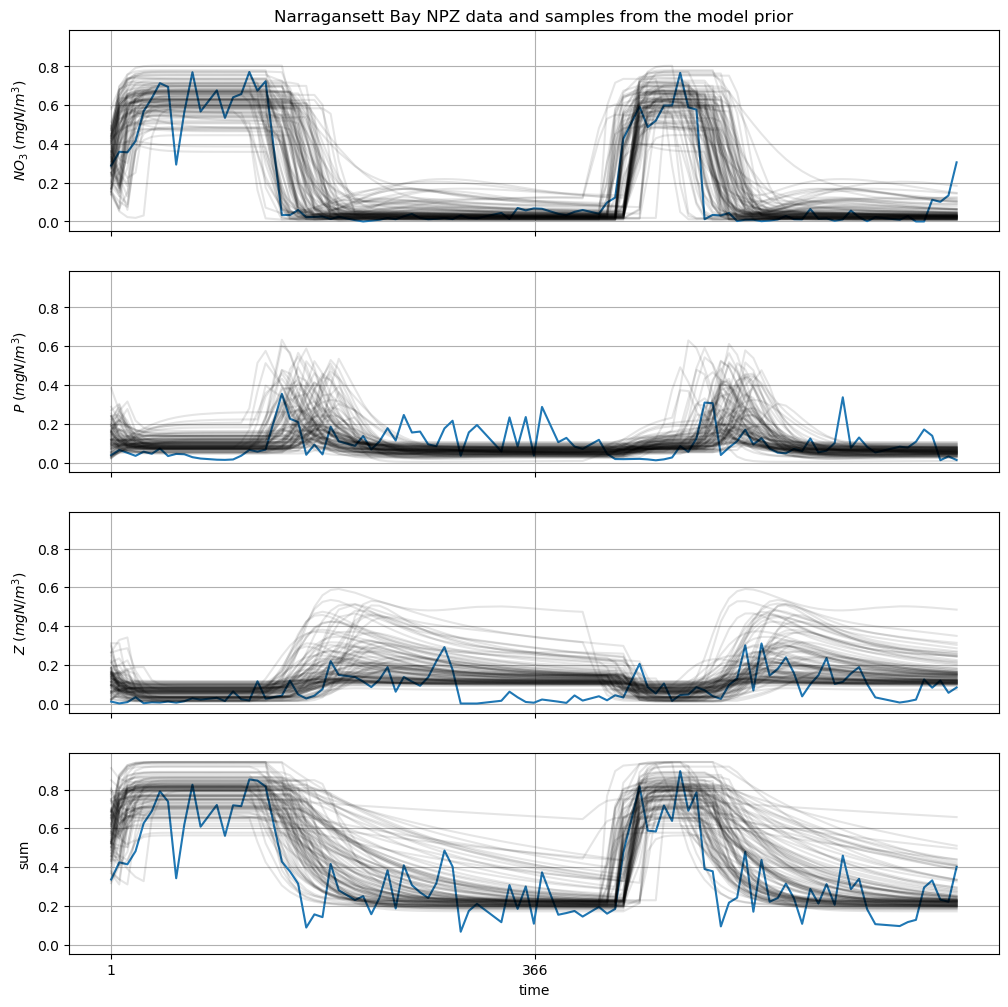

In [15]:
fig, axs = plt.subplots(nrows=4, sharex=true, sharey=true, figsize=(12,12))
for i in 1:3
    axs[i].plot(t, data[index,i+1])
    for j in 1:100
        axs[i].plot(t, priors[j,i,:],color="k", alpha=0.1)
    end
    axs[i].set_ylabel(data_names[i])
    axs[i].grid(true)
end
axs[1].set_title("Narragansett Bay NPZ data and samples from the model prior")
axs[4].plot(t,  data[index,2]+data[index,3]+data[index,4])
for j in 1:100
    axs[4].plot(t, sum(priors,dims=2)[j,1,:], color="k", alpha=0.1)
end
axs[4].set(xlabel="time", ylabel="sum", xticks=collect(1:365:nyears*365.0))
axs[4].grid(true)
plt.show()

### 4. Reparameterizing the model and fitting data
Normally we would use a statement like
```
for(i in 1:nobsvar){
    for (iobs in 1:nobs){
        obs[iobs,i] ~ normal(x[iobs,iobsvar[i]], sigma[i]);
    }
}
```

in Stan's model block to fit the data. When formulated this way, Stan can have trouble sampling from the posterior distribution, for example when `sigma[i]` changes greatly for different values of `x[iobs,iobsvar[i]]`.

Here it helps a lot (decrease in runtime by 1-2 orders of magnitude) to reparameterize the model:
```
for(i in 1:nobsvar){
    for (iobs in 1:nobs){
        obs_normalized = (obs[iobs,i]-x[iobs,iobsvar[i]])/sigma[i];
        obs_normalized ~ std_normal();
    }
}
```
For more information, see the corresponding section in the [Stan user guide](https://mc-stan.org/docs/stan-users-guide/reparameterization-section.html).

In [16]:
# reparameterized model block

stan_code_model = """model {
    real obs_normalized;

    x0[1] ~ normal(0.3, 0.1);         // prior on N initial conditions
    x0[2] ~ normal(0.1, 0.1);         // prior on P initial conditions
    x0[3] ~ normal(0.1, 0.1);         // prior on Z initial conditions

    sigma ~ exponential(1.0);

    // priors for parameters
    vmax       ~ normal(0.15, 0.03);
    nuthalfsat ~ normal(0.17, 0.04);
    graz       ~ normal(0.15, 0.04);
    mort_p     ~ normal(0.02, 0.01);
    mort_z     ~ normal(0.02, 0.005);
    bgconc_n1  ~ normal(0.01, 0.001); // (regular) 
    bgconc_n2  ~ normal(0.66, 0.08);  // (winter) 
    bgconc_p1  ~ normal(0.11, 0.01);  // (regular)
    bgconc_p2  ~ normal(0.05, 0.005); // (winter)
    bgconc_z1  ~ normal(0.09, 0.01);  // (regular)
    bgconc_z2  ~ normal(0.05, 0.03); // (winter)
    mix1       ~ normal(0.01, 0.03); // (regular)
    mix2       ~ normal(0.19, 0.02);  // (winter)
    for (iyear in 1:nyears){
        wintermixstart[iyear]    ~ normal(wintermixstart_guess[iyear], 10.0);
        wintermixduration[iyear] ~ normal(wintermixduration_guess[iyear], 10.0);
    }
    // fitting the observations
    for(i in 1:nobsvar){
        for (iobs in 1:nobs){
            obs_normalized = (obs[iobs,i]-x[iobs,iobsvar[i]])/sigma[i];
            obs_normalized ~ std_normal();
        }
    }
}
""";

In [17]:
stan_code_update = stan_code_functions*stan_code_dataparams*stan_code_model
model_update = SampleModel("NPZ_update", stan_code_update)

In [18]:
(sample_file, log_file) = stan_sample(model_update, data=stan_data, n_chains = 4);

In [19]:
chns_update = read_samples(model_update)

Object of type Chains, with data of type 1000×332×4 Array{Float64,3}

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1, 2, 3, 4
Samples per chain = 1000
internals         = lp__, accept_stat__, stepsize__, treedepth__, n_leapfrog__, divergent__, energy__
parameters        = vmax, nuthalfsat, graz, mort_p, mort_z, bgconc_n1, bgconc_n2, bgconc_p1, bgconc_p2, bgconc_z1, bgconc_z2, mix1, mix2, wintermixstart.1, wintermixstart.2, wintermixduration.1, wintermixduration.2, sigma.1, sigma.2, sigma.3, x0.1, x0.2, x0.3, theta.1, theta.2, theta.3, theta.4, theta.5, theta.6, theta.7, theta.8, theta.9, theta.10, theta.11, theta.12, theta.13, theta.14, theta.15, theta.16, theta.17, x.1.1, x.2.1, x.3.1, x.4.1, x.5.1, x.6.1, x.7.1, x.8.1, x.9.1, x.10.1, x.11.1, x.12.1, x.13.1, x.14.1, x.15.1, x.16.1, x.17.1, x.18.1, x.19.1, x.20.1, x.21.1, x.22.1, x.23.1, x.24.1, x.25.1, x.26.1, x.27.1, x.28.1, x.29.1, x.30.1, x.31.1, x.32.1, x.33.1, x.34.1, x.35.1, x.36.1, x.37.1, x.38.1, x.39.1

In [20]:
ESS = ess(chns_update)

ESS

│ Row │ parameters          │ ess     │ r_hat    │
│     │ Symbol              │ Any     │ Any      │
├─────┼─────────────────────┼─────────┼──────────┤
│ 1   │ vmax                │ 4133.81 │ 0.999716 │
│ 2   │ nuthalfsat          │ 3718.22 │ 1.00095  │
│ 3   │ graz                │ 2849.69 │ 1.00136  │
│ 4   │ mort_p              │ 2570.15 │ 1.00057  │
│ 5   │ mort_z              │ 3159.46 │ 1.00226  │
│ 6   │ bgconc_n1           │ 4123.97 │ 0.999916 │
│ 7   │ bgconc_n2           │ 3782.41 │ 0.999907 │
│ 8   │ bgconc_p1           │ 4102.27 │ 1.00022  │
│ 9   │ bgconc_p2           │ 3635.7  │ 1.00018  │
│ 10  │ bgconc_z1           │ 4130.79 │ 0.999907 │
│ 11  │ bgconc_z2           │ 3185.11 │ 0.999483 │
│ 12  │ mix1                │ 5116.87 │ 0.999332 │
│ 13  │ mix2                │ 4108.63 │ 0.999887 │
│ 14  │ wintermixstart.1    │ 3227.04 │ 1.00079  │
│ 15  │ wintermixstart.2    │ 3213.7  │ 1.00114  │
│ 16  │ wintermixduration.1 │ 3783.25 │ 0.999727 │
│ 17  │ wintermixduration.

In [21]:
rawdata = DataFrame(chns_update, showall=true, sorted=true, append_chains=true);

In [22]:
# reshape the results
dat_summary = zeros(95,3,5)
for i in 1:95
    for j in 1:3
        dat_summary[i,j,1] = mean(rawdata[:,40+3*(i-1)+j])
        dat_summary[i,j,2] = quantile(rawdata[:,40+3*(i-1)+j],0.025)
        dat_summary[i,j,3] = quantile(rawdata[:,40+3*(i-1)+j],0.975)
        dat_summary[i,j,4] = quantile(rawdata[:,40+3*(i-1)+j],0.25)
        dat_summary[i,j,5] = quantile(rawdata[:,40+3*(i-1)+j],0.75)
    end
end

t = data[index,1];

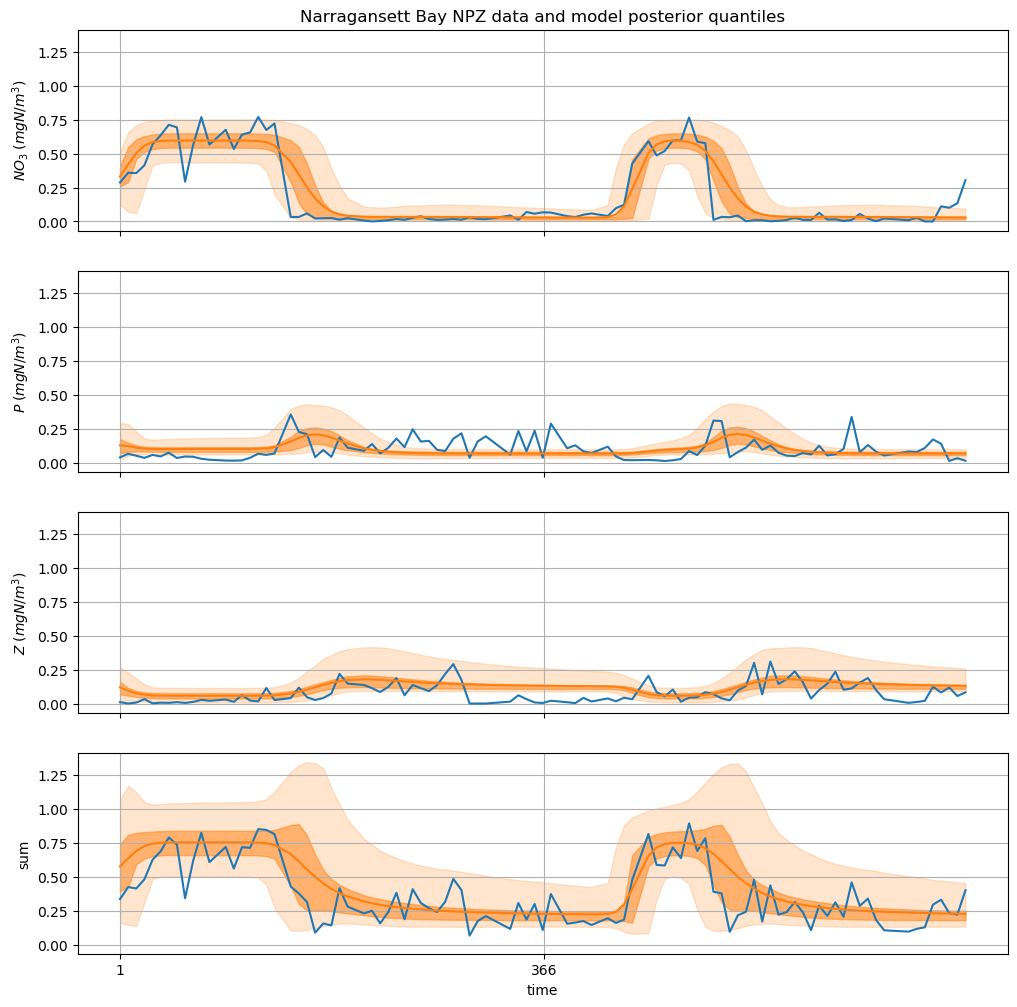

In [23]:
fig, axs = plt.subplots(nrows=4, sharex=true, sharey=true, figsize=(12,12))
for i in 1:3
    axs[i].plot(t, data[index,i+1])
    axs[i].fill_between(t, dat_summary[:,i,2], dat_summary[:,i,3], alpha=0.2, color="C1")
    axs[i].fill_between(t, dat_summary[:,i,4], dat_summary[:,i,5], alpha=0.5, color="C1")
    axs[i].plot(t, dat_summary[:,i,1], label="model", color="C1")
    axs[i].set_ylabel(data_names[i])
    axs[i].grid(true)
end
axs[1].set_title("Narragansett Bay NPZ data and model posterior quantiles")
ax = axs[4]
ax.plot(t,  data[index,2]+data[index,3]+data[index,4])
ax.fill_between(t, sum(dat_summary[:,:,2],dims=2)[:,1], sum(dat_summary[:,:,3],dims=2)[:,1], alpha=0.2, color="C1")
ax.fill_between(t, sum(dat_summary[:,:,4],dims=2)[:,1], sum(dat_summary[:,:,5],dims=2)[:,1], alpha=0.5, color="C1")
ax.plot(t, sum(dat_summary[:,:,1],dims=2)[:,1], label="model", color="C1")
ax.set(xlabel="time", ylabel="sum", xticks=collect(1:365:nyears*365.0))
ax.grid(true)